<a href="https://colab.research.google.com/github/neurontist/LangChain-for-LLM-Application-Development/blob/main/L4%20Question%20and%20Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain: Q&A over Documents
An example might be a tool that would allow you to query a product catalog for items of interest.

In [1]:
!pip install google-ai-generativelanguage==0.6.15
!pip install -qU langchain-google-genai
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 765.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Imports

In [3]:
import os
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')


In [4]:
llm_model = "gemini-1.5-flash"

In [6]:
from langchain.chains import RetrievalQA
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [16]:
llm = ChatGoogleGenerativeAI(temperature=0,model=llm_model, google_api_key=GOOGLE_API_KEY)

In [17]:
file = 'OutdoorClothingCatalog_40.csv'
loader = CSVLoader(file_path=file)

In [18]:
from langchain.indexes import VectorstoreIndexCreator
from langchain_google_genai import GoogleGenerativeAIEmbeddings # Import OpenAIEmbeddings or any other embedding model

In [12]:
!pip install docarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 9.1 MB/s eta 0:00:00


### Creating a vector store

In [20]:
# For Gemini embeddings
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=GoogleGenerativeAIEmbeddings(
        model="models/embedding-001", # This line is crucial for Gemini embeddings
        google_api_key=GOOGLE_API_KEY
        ),
).from_loaders([loader])

### Querying the store

In [21]:
query ="Please list all Cargo Shorts \
in a table in markdown and summarize each one."

In [23]:
response = index.query(query,llm)

In [24]:
display(Markdown(response))

| Product Name | Category | Price | Stock Availability | Rating | Summary |
|---|---|---|---|---|---|
| Cargo Shorts | Shirts | 147.38 | Out of Stock | 1.1 | Cargo shorts categorized under shirts, priced at 147.38, out of stock, and has a low rating of 1.1. |
| Cargo Shorts | Accessories | 171.46 | Out of Stock | 3.9 | Cargo shorts categorized under accessories, priced at 171.46, out of stock, and has a rating of 3.9. |

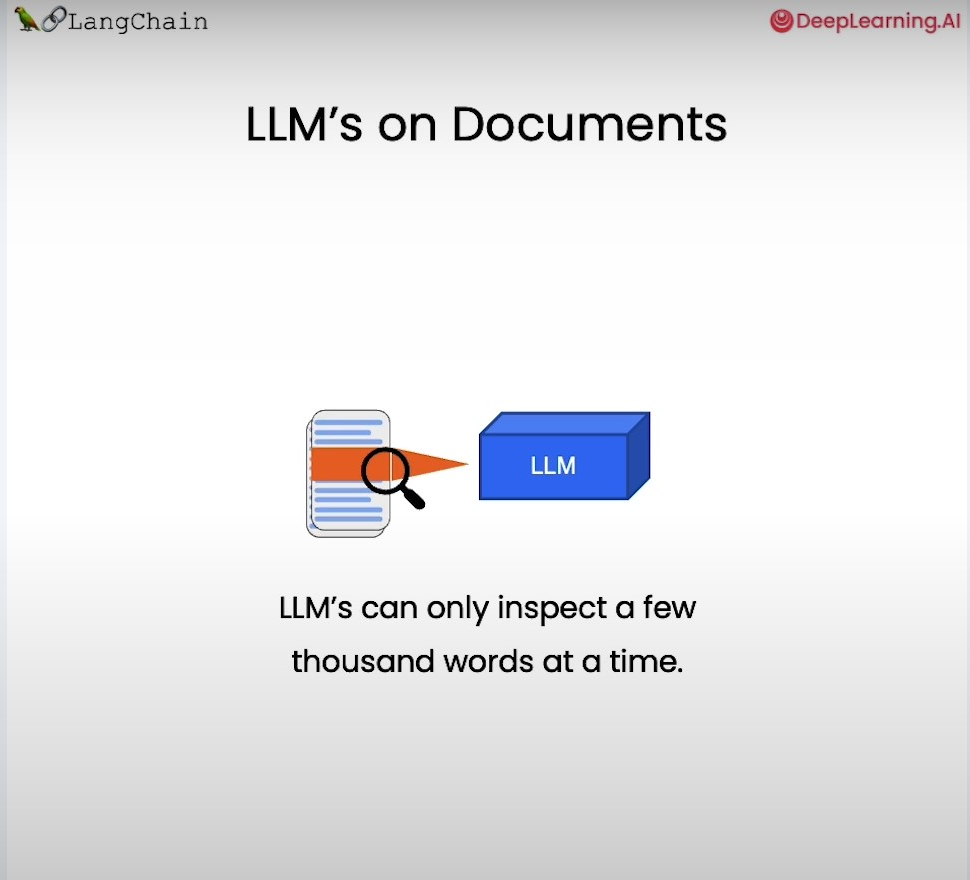

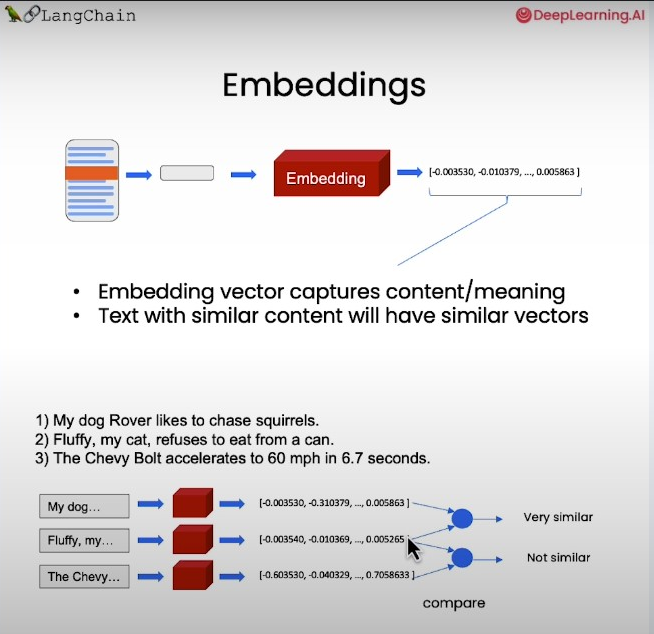

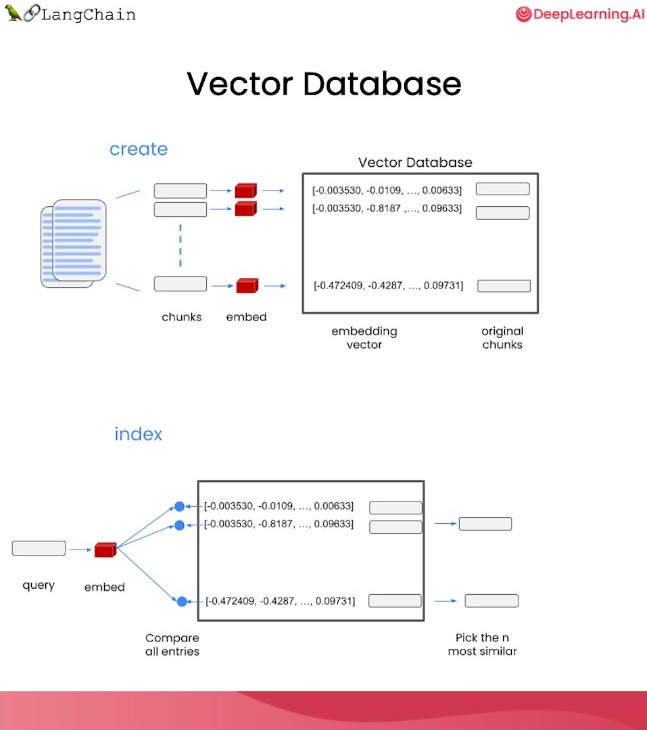

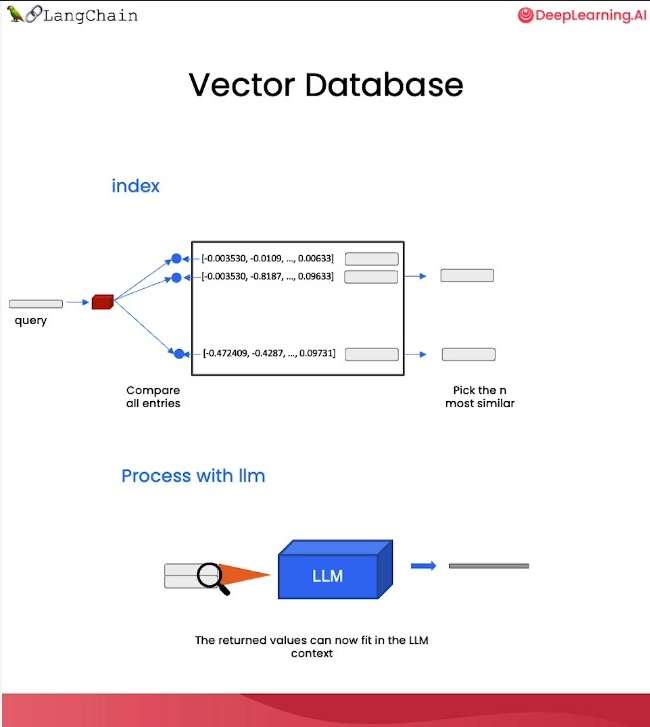

# Step-by-Step

What happening inside the function?

In [25]:
from langchain.document_loaders import CSVLoader
loader = CSVLoader(file_path=file)

In [26]:
docs = loader.load()

In [27]:
docs[0]

Document(metadata={'source': 'OutdoorClothingCatalog_40.csv', 'row': 0}, page_content='Product Name: Fleece Jacket\nCategory: Gloves\nPrice: 109.18\nStock Availability: In Stock\nRating: 4.6')

### Embeddings

In [30]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=GOOGLE_API_KEY
)

In [31]:
embed = embeddings.embed_query("Hi my name is Aliza")

In [32]:
print(len(embed))

768


In [33]:
print(embed[:10])

[0.06501401960849762, -0.0124604357406497, -0.02235284075140953, -0.0012815361842513084, 0.0494811087846756, 0.020269669592380524, 0.019435198977589607, -0.04467032477259636, 0.0009282553219236434, -0.005009533371776342]


### Using DocArrayInMemorySearch

In [34]:
db = DocArrayInMemorySearch.from_documents(
    docs,
    embeddings
)

In [35]:
query = "Please find a Beanie Hat which is out of stock and it's category "

In [36]:
docs = db.similarity_search(query)

In [37]:
len(docs)

4

In [38]:
docs[0]

Document(metadata={'source': 'OutdoorClothingCatalog_40.csv', 'row': 34}, page_content='Product Name: Beanie Hat\nCategory: Gloves\nPrice: 284.52\nStock Availability: Out of Stock\nRating: 4.8')

### Calling the retriever()

In [39]:
retriever = db.as_retriever()

In [40]:
qdocs = "".join([docs[i].page_content for i in range(len(docs))])


In [42]:
response = llm.invoke(f"{qdocs} Question: Please list all your \
Beanie Hat in a table in markdown and summarize each one.")


In [44]:
display(Markdown(response.content))

| Product Name | Category | Price | Stock Availability | Rating | Summary |
|---|---|---|---|---|---|
| Beanie Hat | Gloves | 284.52 | Out of Stock | 4.8 | An expensive beanie hat, highly rated but currently unavailable. |
| Beanie Hat | Jackets | 221.88 | In Stock | 3.1 | A moderately priced beanie hat categorized under jackets, with a lower rating. |

### Querying the retrieved docs through embeddings

In [45]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)

In [46]:
query =  "Please list all your \
Beanie Hat in a table in markdown and summarize each one. "

In [47]:
response = qa_stuff.run(query)

<ipython-input-47-86a6164ed552>:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_stuff.run(query)




> Entering new RetrievalQA chain...

> Finished chain.


In [48]:
display(Markdown(response))

| Product Name | Category | Price | Stock Availability | Rating | Summary |
|---|---|---|---|---|---|
| Beanie Hat | Jackets | $221.88 | In Stock | 3.1 | A beanie hat categorized under jackets, priced at $221.88, currently in stock with a 3.1 rating. |
| Beanie Hat | Gloves | $284.52 | Out of Stock | 4.8 | A beanie hat categorized under gloves, priced at $284.52, currently out of stock with a 4.8 rating. |

### Above same achieved in 2 steps

In [49]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings,
).from_loaders([loader])

In [55]:
response = index.query(query, llm=llm)
display(Markdown(response))

| Product Name | Category | Price | Stock Availability | Rating | Summary |
|---|---|---|---|---|---|
| Beanie Hat | Jackets | $221.88 | In Stock | 3.1 | A beanie hat categorized under jackets, priced at $221.88, currently in stock with a 3.1 rating. |
| Beanie Hat | Gloves | $284.52 | Out of Stock | 4.8 | A beanie hat categorized under gloves, priced at $284.52, currently out of stock with a 4.8 rating. |